**Construct a bayesian model with the catboot prediction as input (y1_cb_train)**


# Preliminaries

In [ ]:
#@title Install libraries
%%capture
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
#!pip install vincenty

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/gdrive')

import os
import sys

os.chdir(r'/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB')
if "." not in sys.path:
  sys.path.append(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
#@title GPU/CPU, RAM info
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('No GPU')
# else:
#   print(gpu_info)

# Check GPU is available
# https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
# import tensorflow as tf
# tf.test.gpu_device_name()

# List of CPU
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


In [ ]:
#@title import libraries
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import time
import copy

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import catboost
import tensorflow as tf

# My helpers
import helpers.run_model as run_model
import helpers.tune_model as tune_model
#import helpers.data_prep as data_prep

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.options.display.float_format = '{:.03f}'.format

sns.set(color_codes=True)

# Reimport after change
import importlib
# importlib.reload(run_model)  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [ ]:
#@title Load dataset
DATA_DIR = 'data/'
SEED_FOR_SPLIT = 0  # random_state for split
#x_train = pickle.load(open(DATA_DIR + 'x_train.beforeOneHot.pickle', 'rb'))
x_train = pd.read_csv(DATA_DIR+'prepared/x_train.csv.zip', compression='zip')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')
x_test = pd.read_csv(DATA_DIR+'prepared/x_test.csv.zip', compression='zip')

print('shapes: ', x_train.shape, y_train.shape)

# -- Categorical features
cat_features = ['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 
                'location of the event', 
                'emergency vehicle', 
                #'emergency vehicle type', 
                'vehicule_type', 'vehicule_owner',
                'rescue center', 
                'status preceding selection', 'departed from its rescue center', 
                'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday',
                'waypoint1_name', 'waypoint2_name',
                'intervention_place', # 20200420
                'waypoint3_name', 'waypoint4_name',
                ]
cat_features_idx = [i for i, name in enumerate(x_train.columns) if name in cat_features]

# -- Target variables
Y_NAMES = list(y_train.columns[1:].values)
print(Y_NAMES)
print(cat_features)
print(cat_features_idx)
# y_name by default
y_name = Y_NAMES[1]
print('y_name by default', y_name)

# -- split
x_train_sp, x_test_sp, y_train_sp, y_test_sp = train_test_split(
    x_train,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('Split dataset shapes', x_train.shape, x_test_sp.shape)

shapes:  (219337, 64) (219337, 4)
['delta selection-departure', 'delta departure-presentation', 'delta selection-presentation']
['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_owner', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday', 'waypoint1_name', 'waypoint2_name', 'intervention_place', 'waypoint3_name', 'waypoint4_name']
[0, 1, 2, 3, 4, 7, 8, 11, 13, 23, 24, 25, 26, 27, 32, 35, 38, 41, 60, 61, 63]
y_name by default delta departure-presentation
Split dataset shapes (219337, 64) (72382, 64)


In [ ]:
#@title restrict datatset for y0
# Restricts features set
feats_4y0 = ['paris2departure_km',
            'paris2departure_bearing',
            'longitude before departure',
            'latitude before departure',
            'alert reason category',
            'alert reason',
            'intervention on public roads',
            'location of the event',
            'emergency vehicle',
            #'emergency vehicle type',
            'vehicule_type', 'vehicule_owner',
            'rescue center',
            'status preceding selection',
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'date key sélection',
            'time key sélection',
            'selection_weekday',
            'selection_month',
            'selection_day',
            'selection_hour',
            'selection_is_holiday',
            'time elapsed between selection and last observed GPS position', 
            'updated OSRM estimated duration',
            'delta position gps previous departure-departure',
            ]
x_train_4y0 = x_train[feats_4y0]
x_test_4y0 = x_test[feats_4y0]
cat_features_4y0 = [c for c in cat_features if c in feats_4y0]
cat_features_4y0_idx = [i for i, c in enumerate(x_train_4y0.columns) if c in cat_features_4y0]
x_train_sp_4y0, x_test_sp_4y0, y_train_sp, y_test_sp = train_test_split(
    x_train_4y0,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('cat_features_4y0:', cat_features_4y0)
print('x_train shape before/after', x_train.shape, x_train_sp_4y0.shape)

cat_features_4y0: ['alert reason category', 'alert reason', 'intervention on public roads', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_owner', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday']
x_train shape before/after (219337, 64) (146955, 25)


In [ ]:
x_train_sp.shape

(146955, 64)

# Reload model

In [ ]:
#@title Reload model for Y1 (trained with all train dataset)
# poor R2 / Y0

mY1 = catboost.CatBoostRegressor()
mY1 = mY1.load_model('models/catboost.Y1.splitdata.model')
# Recent bugs in catboost
mY1._init_params["verbose"]=None

In [ ]:
y_name

'delta departure-presentation'

In [ ]:
y1_cb_train = mY1.predict(x_train_sp)
y1_cb_test = mY1.predict(x_test_sp)

y1_cb_train = y1_cb_train.reshape((-1,1))
y1_cb_test = y1_cb_test.reshape((-1,1))

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# y1_cb_train = scaler.fit_transform(X=y1_cb_train)
# y1_cb_test = scaler.transform(X=y1_cb_test)


<Figure size 1080x576 with 0 Axes>

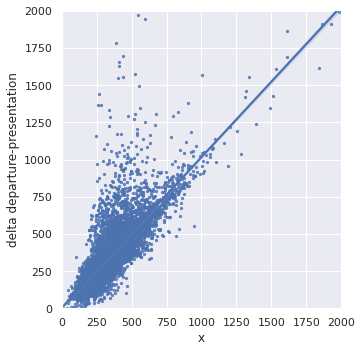

In [ ]:
df = pd.concat([pd.DataFrame({'x': y1_cb_train.squeeze()}, index=y_train_sp.index), 
                y_train_sp[y_name]], axis=1)
df.sort_values("x", inplace=True)

plt.figure(figsize=(15,8))
g = sns.lmplot(x='x', y=y_name, data=df.sample(10000), scatter_kws={"s": 5})
g.set(ylim=(0, 2000), xlim=(0, 2000))


In [ ]:
df.shape

(146955, 2)

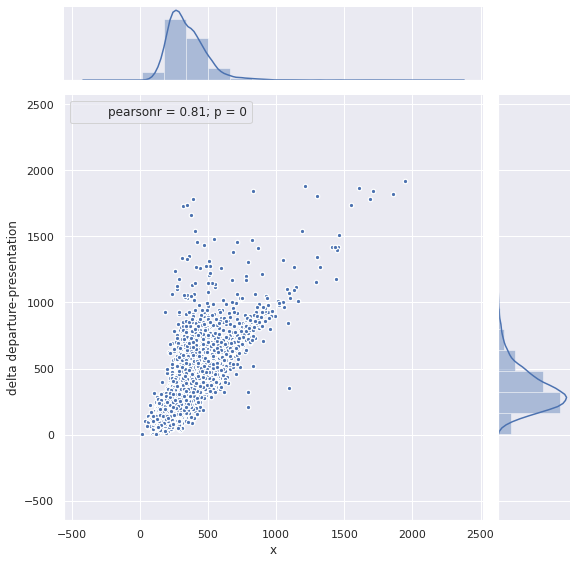

In [ ]:
gd = sns.jointplot(
    x="x",
    y=y_name,
    data=df[(df.x <= 2000) &
            (df[y_name]  <= 2000)
           ].sample(10000),
    kind="scatter",
    height=8,
    marginal_kws={"bins": 12, "kde": True, 
                  "kde_kws": {"cut": 20}
                  },
    joint_kws={"edgecolor": "w", "linewidth": 1.2, "s": 20},
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # hide warning for presentation: annotate on JointGrid
    _ = gd.annotate(stats.pearsonr, loc="upper left", fontsize=12)


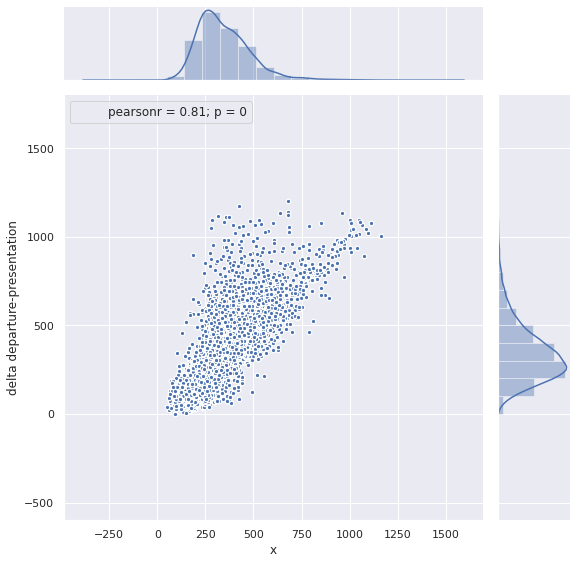

In [ ]:
gd = sns.jointplot(
    x="x",
    y=y_name,
    data=df[(df.x <= 1200) &
            (df[y_name]  <= 1200)
           ].sample(10000),
    kind="scatter",
    height=8,
    marginal_kws={"bins": 12, "kde": True, 
                  "kde_kws": {"cut": 20}
                  },
    joint_kws={"edgecolor": "w", "linewidth": 1.2, "s": 20},
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # hide warning for presentation: annotate on JointGrid
    _ = gd.annotate(stats.pearsonr, loc="upper left", fontsize=12)

# Sckitlearn Linear Model

In [ ]:
ALL_RESULTS=[]

In [ ]:
#@title Scikit Linear Model for Y1 (departure-presentation)
from sklearn import linear_model
try:ALL_RESULTS
except NameError: ALL_RESULTS=[]
y_name = Y_NAMES[1]
model = linear_model.RidgeCV(alphas=[0.0], cv=5)
name = f'Ridge cv'
_, ALL_RESULTS_DF = run_model.run_new_model(
      y_name=y_name,
      name=name,
      model=model,
      x_train=y1_cb_train, y_train=y_train_sp[y_name],
      x_test=y1_cb_test, y_test=y_test_sp[y_name],
      results=ALL_RESULTS
  )
ALL_RESULTS_DF

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
0,Ridge cv,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.063661,"RidgeCV(alphas=array([0.]), cv=5, fit_intercep..."


In [ ]:
#@title Statsmodels OLS for Y1 (departure-presentation)
import statsmodels.api as sm

# Add constant
x_tr = np.c_[y1_cb_train, np.ones_like(y1_cb_train)]
x_tst = np.c_[y1_cb_test, np.ones_like(y1_cb_test)]

ols = sm.OLS(endog=y_train_sp[y_name], 
             exog=x_tr)
_, ALL_RESULTS_DF = run_model.run_new_model(
            y_name=y_name,
            name='statsmodel ols',
            model=ols,
            x_train=x_tr,
            y_train=y_train_sp[y_name],
            x_test=x_tst,
            y_test=y_test_sp[y_name],
            results=ALL_RESULTS
            )
ALL_RESULTS_DF

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
0,Ridge cv,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.063661,"RidgeCV(alphas=array([0.]), cv=5, fit_intercep..."
1,statsmodel ols,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.015168,<statsmodels.regression.linear_model.Regressio...


In [ ]:
ols_res = ALL_RESULTS[1].model
ols_res_summary = ols_res.summary()
print(ols_res_summary)

                                 OLS Regression Results                                 
Dep. Variable:     delta departure-presentation   R-squared:                       0.539
Model:                                      OLS   Adj. R-squared:                  0.539
Method:                           Least Squares   F-statistic:                 1.721e+05
Date:                          Sat, 22 Aug 2020   Prob (F-statistic):               0.00
Time:                                  19:14:17   Log-Likelihood:            -9.4738e+05
No. Observations:                        146955   AIC:                         1.895e+06
Df Residuals:                            146953   BIC:                         1.895e+06
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
# import importlib
# importlib.reload(run_model)

In [ ]:
#@title statsmodels Robust Regression
rlm = sm.RLM(endog=y_train_sp[y_name], 
       exog=y1_cb_train, 
       M=sm.robust.norms.HuberT())
_, ALL_RESULTS_DF = run_model.run_new_model(
            y_name=y_name,
            name='statsmodel robust regression',
            model=rlm,
            x_train=y1_cb_train, 
            y_train=y_train_sp[y_name],
            x_test=y1_cb_test, 
            y_test=y_test_sp[y_name],
            results=ALL_RESULTS
            )
ALL_RESULTS_DF

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
0,Ridge cv,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.063661,"RidgeCV(alphas=array([0.]), cv=5, fit_intercep..."
1,statsmodel ols,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.015168,<statsmodels.regression.linear_model.Regressio...
2,statsmodel robust regression,delta departure-presentation,31985.264010,0.533272,31985.264010,0.422628,0.367102,<statsmodels.robust.robust_linear_model.RLMRes...


In [ ]:
#@title Scikit Linear Ridge with alpha = 0.01, 0.1, 0.5
from sklearn import linear_model
try:ALL_RESULTS
except NameError: ALL_RESULTS=[]
y_name = Y_NAMES[1]
model = linear_model.RidgeCV(alphas=[0.01, 0.1, 0.5], cv=5)
name = f'Ridge cv with alphas'
_, ALL_RESULTS_DF = run_model.run_new_model(
      y_name=y_name,
      name=name,
      model=model,
      x_train=y1_cb_train, y_train=y_train_sp[y_name],
      x_test=y1_cb_test, y_test=y_test_sp[y_name],
      results=ALL_RESULTS
  )
ALL_RESULTS_DF

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
0,Ridge cv,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.063661,"RidgeCV(alphas=array([0.]), cv=5, fit_intercep..."
1,statsmodel ols,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.015168,<statsmodels.regression.linear_model.Regressio...
2,statsmodel robust regression,delta departure-presentation,31985.264010,0.533272,31985.264010,0.422628,0.367102,<statsmodels.robust.robust_linear_model.RLMRes...
3,Ridge cv with alphas,delta departure-presentation,31801.819182,0.539444,31801.819182,0.425939,0.129678,"RidgeCV(alphas=array([0.01, 0.1 , 0.5 ]), cv=5..."


# PyMC GLM


*   https://pymc3.readthedocs.io/en/latest/notebooks/GLM-robust-with-outlier-detection.html?highlight=hogg
*   https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/GLM-robust-with-outlier-detection.ipynb



In [ ]:
%%capture
!pip install 'pymc3>=3.8'

import theano
import pymc3 as pm
pm.__version__

In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from matplotlib.lines import Line2D
from scipy import stats

In [ ]:
xy_train_sp = np.c_[y1_cb_train, y_train_sp[y_name]]

In [ ]:
xy_train_sp = pd.DataFrame(xy_train_sp, columns=['x', 'y'])
xy_train_sp.head(3)

,x,y
0,300.552479,460.0
1,187.498668,175.0
2,134.923255,177.0


In [ ]:
# with pm.Model() as m_pymc:
#     pm.glm.GLM.from_formula('y ~ x + constant', xy_train_sp.to_dict())
#     trace = pm.sample(2000)

**Memory crash**


## Simple OLS Model with Normal Likelihood (Ridge)
https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/GLM-robust-with-outlier-detection.ipynb

In [ ]:
xy_train_small = xy_train_sp.head(2000)

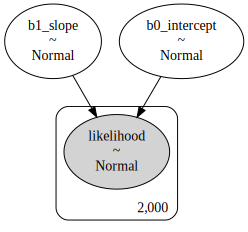

In [ ]:
with pm.Model() as mdl_ols:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept", mu=0, sigma=60*2)
    b1 = pm.Normal("b1_slope", mu=0, sigma=5)

    ## Define linear model
    y_est = b0 + b1 * xy_train_small["x"]

    ## Define Normal likelihood
    likelihood = pm.Normal(
        "likelihood", 
        mu=y_est, 
        sigma=xy_train_sp['y'].std(), # fix sigma
        observed=xy_train_small["y"]
    )

pm.model_to_graphviz(mdl_ols)

In [ ]:
with mdl_ols:
    trc_ols = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )


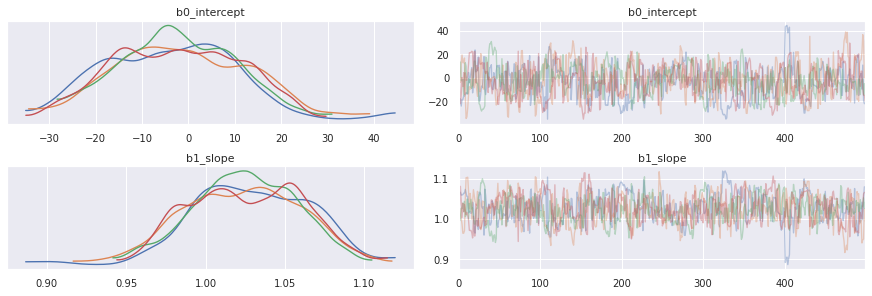

In [ ]:
_ = az.plot_trace(trc_ols)

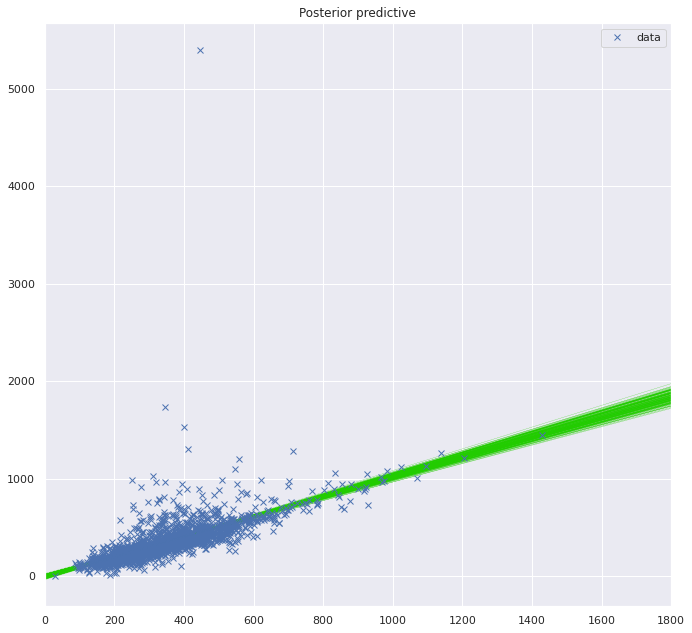

In [ ]:
# plot posterior distributions
xmin, xmax = 0, 1800
lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x
pm.plot_posterior_predictive_glm(
    trc_ols,
    lm=lm,
    eval=np.linspace(xmin, xmax, 10),
    samples=200,
    color="#22CC00",
    # alpha=0.3,
    # zorder=2,
)
plt.plot(xy_train_small.x, xy_train_small.y, 'x', label='data')
plt.legend(loc=0)
plt.xlim((xmin, xmax))
plt.ylim;((0, 2000));


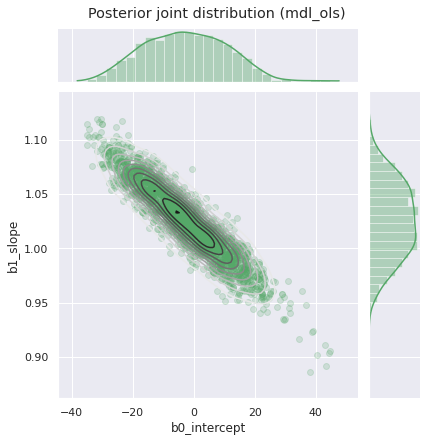

In [ ]:
df_trc_ols = pm.trace_to_dataframe(trc_ols)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_ols,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=sns.color_palette()[2],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_ols)", y=1.02)


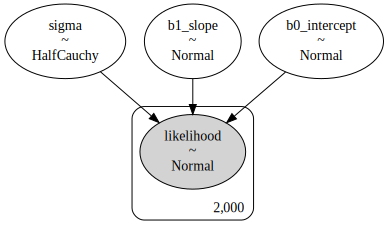

In [ ]:
with pm.Model() as mdl_ols2:
  # Add prior for sigma
  sigma = pm.HalfCauchy('sigma', beta=10, testval=120.)
  ## Define weakly informative Normal priors to give Ridge regression
  b0 = pm.Normal("b0_intercept", mu=0, sigma=60*2)
  b1 = pm.Normal("b1_slope", mu=0, sigma=5)

  ## Define linear model
  y_est = b0 + b1 * xy_train_small["x"]

  ## Define Normal likelihood
  likelihood = pm.Normal(
      "likelihood", 
      mu=y_est, 
      sigma=sigma,
      observed=xy_train_small["y"]
  )

pm.model_to_graphviz(mdl_ols2)

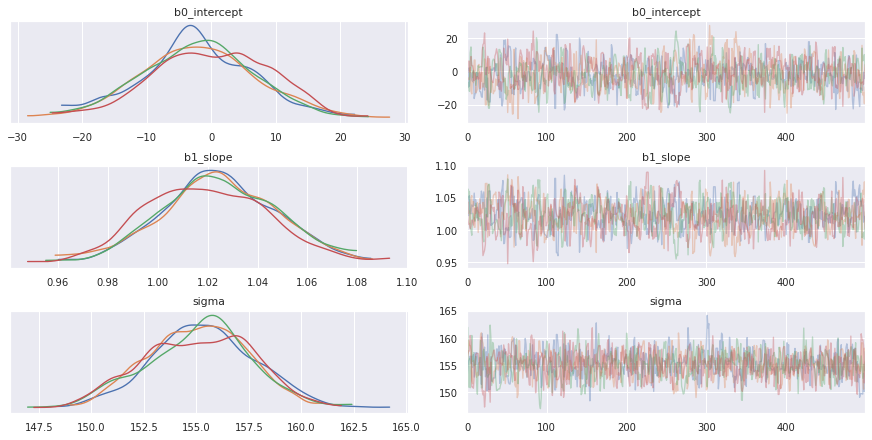

In [ ]:
def sample_and_plot(mdl):
  with mdl:
    trc = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )
  az.plot_trace(trc_ols2);
  return trc

trc_ols2 = sample_and_plot(mdl_ols2)

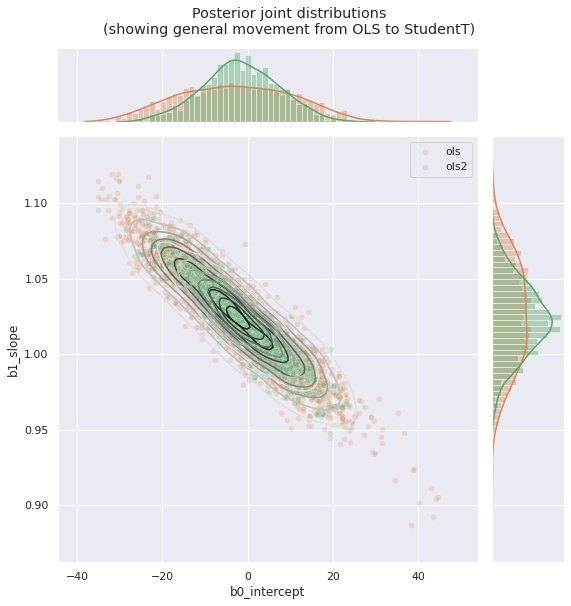

In [ ]:
def concat_multi_model_traces(traces, model_names):
  # fts = ["b0_intercept", "b1_slope"]
  # df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts]), sort=False)
  # df_trc["model"] = pd.Categorical(
  #     np.repeat(["ols", "studentt"], len(df_trc_ols)),
  #     categories=["empty_force_cmap", "studentt", "ols"],
  #     ordered=True,
  # )
  fts = ["b0_intercept", "b1_slope"]
  df_trc = pd.concat(
      [pm.trace_to_dataframe(trc) for trc in traces],
      sort=False
  )
  df_trc["model"] = pd.Categorical(
      np.repeat(model_names, int(len(df_trc)/len(traces))),
      categories=["empty_force_cmap", *model_names],
      ordered=True,
  )
  return df_trc


def plot_multi_model_traces(df_trc):
  gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
  _ = gd.fig.suptitle(
      (
          "Posterior joint distributions"
          + "\n(showing general movement from OLS to StudentT)"
      ),
      y=1.05,
  )

  _, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
  _, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

  kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
  dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

  for idx, grp in df_trc.groupby("model"):

      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          # cheap hack to ignore warnings from plot empty categorical grp

          _ = sns.scatterplot(
              grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx
          )
          _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, **kde_kws)
          _ = sns.distplot(
              grp["b0_intercept"], bins=x_bin_edges, ax=gd.ax_marg_x, **dist_kws
          )
          _ = sns.distplot(grp["b1_slope"], vertical=True, bins=y_bin_edges,
              ax=gd.ax_marg_y, **dist_kws
          )
  _ = gd.ax_joint.legend()

df_trc = concat_multi_model_traces(traces=[trc_ols, trc_ols2], 
                                   model_names=['ols', 'ols2'])
plot_multi_model_traces(df_trc);

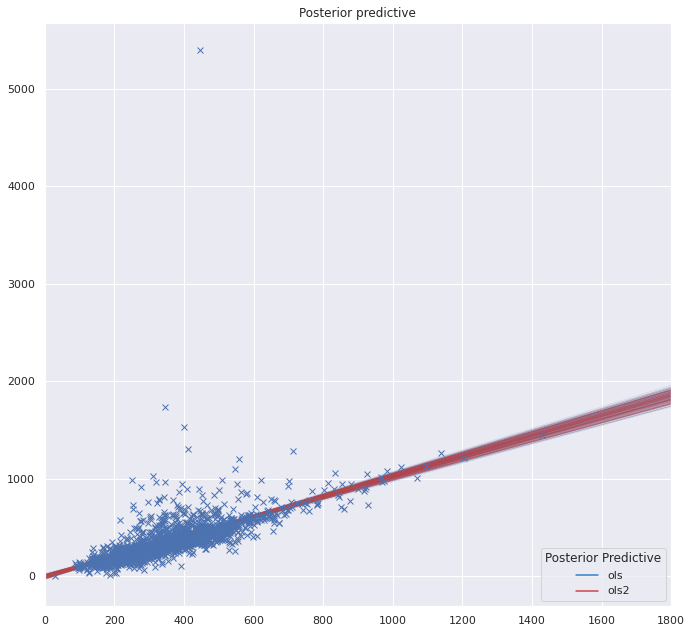

In [ ]:
# plot posterior distributions
def plot_posterior_dist(traces, names):
  xmin, xmax = 0, 1800
  colors = ["#357EC7", "#CC4444", "#FFA500", "#22CC00"]
  for i, s in enumerate(traces):
    lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x
    pm.plot_posterior_predictive_glm(
        trc_ols,
        lm=lm,
        eval=np.linspace(xmin, xmax, 10),
        samples=200,
        color=colors[i],
        alpha=0.3,
        # zorder=2,
    )
  line_legend = plt.legend(
    [Line2D([0], [0], color=colors[i]) for i in range(len(traces))],
    names,
    loc="lower right",
    title="Posterior Predictive",
  )
  #_ = gd.fig.get_axes()[0].add_artist(line_legend)

  plt.plot(xy_train_small.x, xy_train_small.y, 'x', label='data')
  #plt.legend(loc=0)
  plt.xlim((xmin, xmax))
  plt.ylim;((0, 2000));

plot_posterior_dist(traces=[trc_ols, trc_ols2], names=['ols', 'ols2'])

## Simple Linear Model with Robust Student-T Likelihood

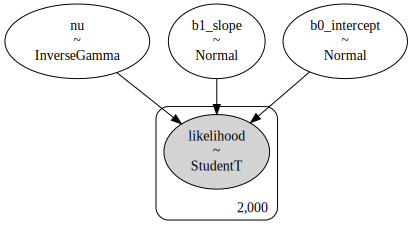

In [ ]:
with pm.Model() as mdl_studentt:

    # define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept", mu=0, sd=10)
    b1 = pm.Normal("b1_slope", mu=0, sd=10)

    # define linear model
    y_est = b0 + b1 * xy_train_small["x"]

    # define prior for StudentT degrees of freedom
    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", 
        mu=y_est, 
        sigma=xy_train_sp['y'].std(), 
        nu=nu, 
        observed=xy_train_small["y"]
    )

pm.model_to_graphviz(mdl_studentt)


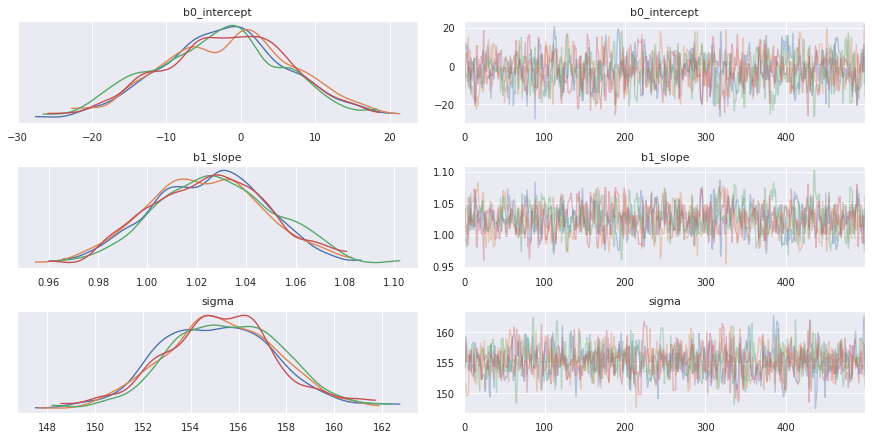

In [ ]:
trc_studentt = sample_and_plot(mdl_studentt)

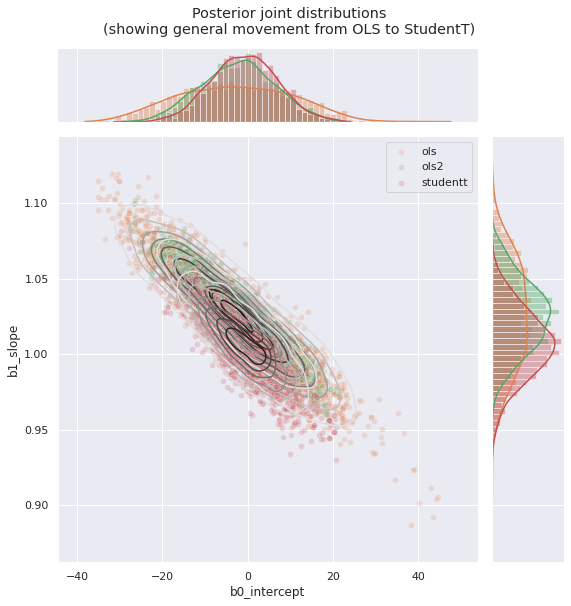

In [ ]:
df_trc = concat_multi_model_traces(traces=[trc_ols, trc_ols2, trc_studentt], 
                                   model_names=['ols', 'ols2', 'studentt'])
plot_multi_model_traces(df_trc);

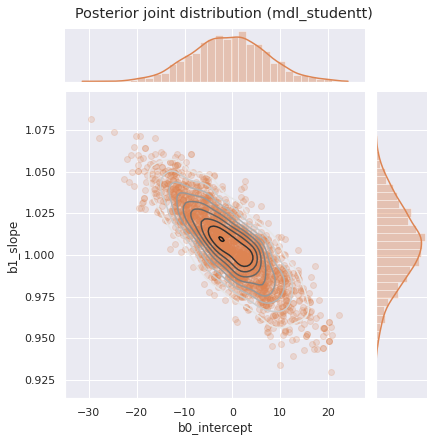

In [ ]:
df_trc_studentt = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_studentt,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
    color=sns.color_palette()[1],
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_studentt)", y=1.02)


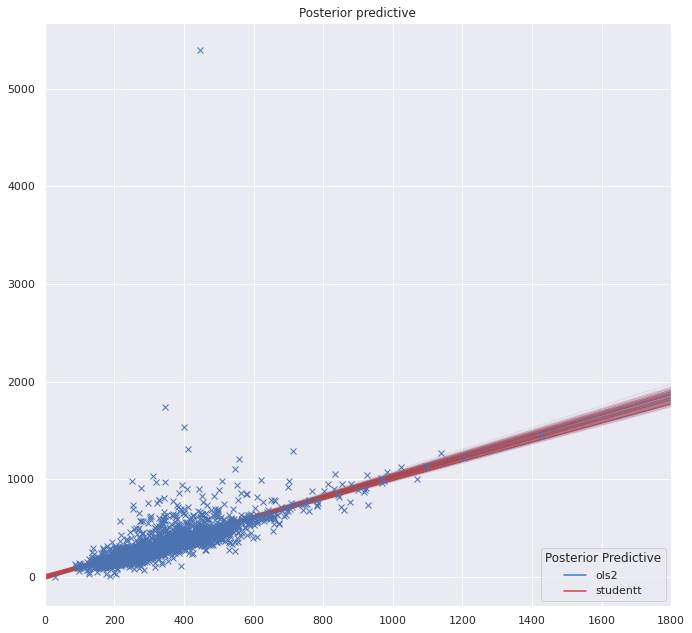

In [ ]:
plot_posterior_dist(traces=[trc_ols2, trc_studentt], names=['ols2', 'studentt'])

## Linear Model with Custom Likelihood to Distinguish Outliers: Hogg Method


In [ ]:
with pm.Model() as mdl_hogg:

    # state input data as Theano shared vars
    tsv_x = pm.Data("tsv_x", xy_train_small["x"])  # (n, )
    tsv_y = pm.Data("tsv_y", xy_train_small["y"])  # (n, )
    # tsv_sigma_y = pm.Data("tsv_sigma_y", dfhoggs["sigma_y"])  # (n, )
    tsv_sigma_y = xy_train_sp.y.std()

    # weakly informative Normal priors (L2 ridge reg) for inliers
    b0 = pm.Normal("b0_intercept", mu=0, sigma=5, testval=pm.floatX(0.0))
    b1 = pm.Normal("b1_slope", mu=0, sigma=5, testval=pm.floatX(1.0))

    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x  # (n, )

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=10, testval=pm.floatX(0.0))  # (1, )

    # very weakly informative prior for additional variance for outliers
    sigma_y_out = pm.HalfNormal(
        "sigma_y_out", sigma=10, testval=pm.floatX(1.0)
    )  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(
        tsv_y
    )

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=tsv_x.eval().shape[0],
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.4) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

# pm.model_to_graphviz(mdl_signoise) commented out: the plot is too complicated


In [ ]:
with mdl_hogg:
    trc_hogg = pm.sample(
        tune=10000,
        draws=500,
        chains=4,
        cores=4,
        init="jitter+adapt_diag",
        nuts={"target_accept": 0.9},
    )


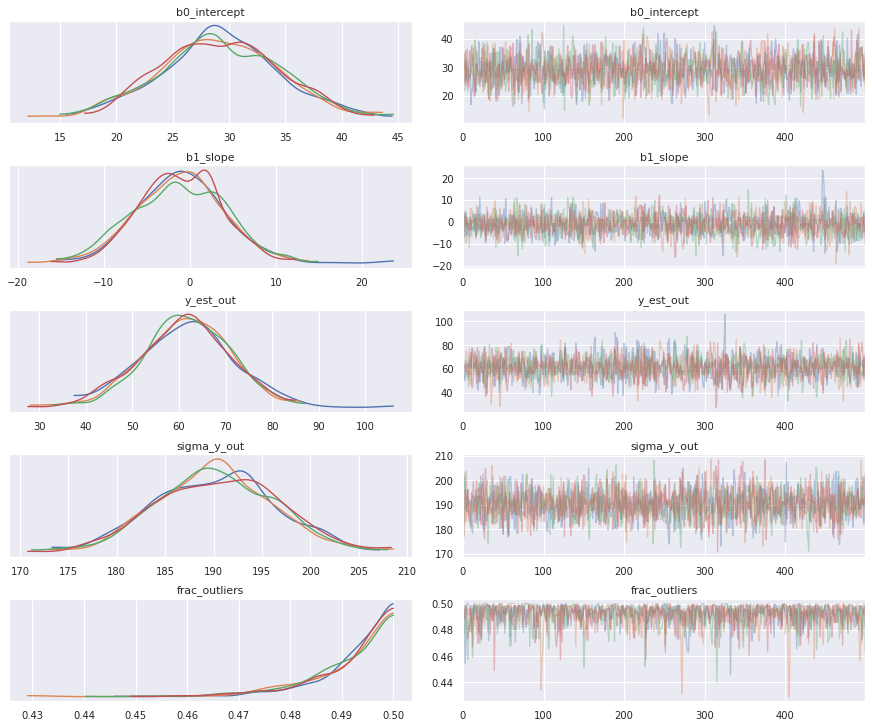

In [ ]:
rvs = ["b0_intercept", "b1_slope", "y_est_out", "sigma_y_out", "frac_outliers"]
_ = az.plot_trace(trc_hogg, var_names=rvs)


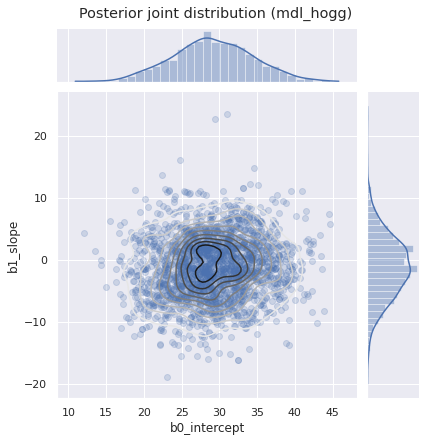

In [ ]:
df_trc_hogg = pm.trace_to_dataframe(trc_hogg)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_hogg,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (mdl_hogg)", y=1.02)

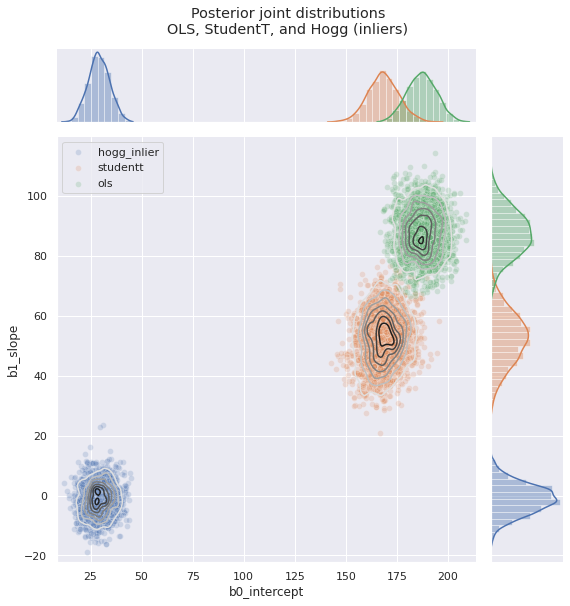

In [ ]:
fts = ["b0_intercept", "b1_slope"]
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts], df_trc_hogg), sort=False)
df_trc["model"] = pd.Categorical(
    np.repeat(["ols", "studentt", "hogg_inlier"], len(df_trc_ols)),
    categories=["hogg_inlier", "studentt", "ols"],
    ordered=True,
)

gd = sns.JointGrid(x="b0_intercept", y="b1_slope", data=df_trc, height=8)
_ = gd.fig.suptitle(
    ("Posterior joint distributions" + "\nOLS, StudentT, and Hogg (inliers)"), y=1.05
)

_, x_bin_edges = np.histogram(df_trc["b0_intercept"], 60)
_, y_bin_edges = np.histogram(df_trc["b1_slope"], 60)

kde_kws = dict(zorder=2, n_levels=7, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for idx, grp in df_trc.groupby("model"):
    _ = sns.scatterplot(
        grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, alpha=0.2, label=idx
    )
    _ = sns.kdeplot(grp["b0_intercept"], grp["b1_slope"], ax=gd.ax_joint, **kde_kws)
    _ = sns.distplot(grp["b0_intercept"], **dist_kws, bins=x_bin_edges, ax=gd.ax_marg_x)
    _ = sns.distplot(
        grp["b1_slope"], **dist_kws, vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y
    )
_ = gd.ax_joint.legend()

## Declare outliers

In [ ]:
df_outlier_results = pd.DataFrame.from_records(
    trc_hogg["is_outlier"], columns=xy_train_small.index
)
dfm_outlier_results = pd.melt(
    df_outlier_results, var_name="datapoint_id", value_name="is_outlier"
)

dfm_outlier_results.groupby('datapoint_id')['is_outlier'].sum()

datapoint_id
576       1346
1003       756
1173       976
2078       939
2791       878
          ... 
146140     703
146836    1093
146863    1201
146888     904
146916     927
Name: is_outlier, Length: 500, dtype: int64

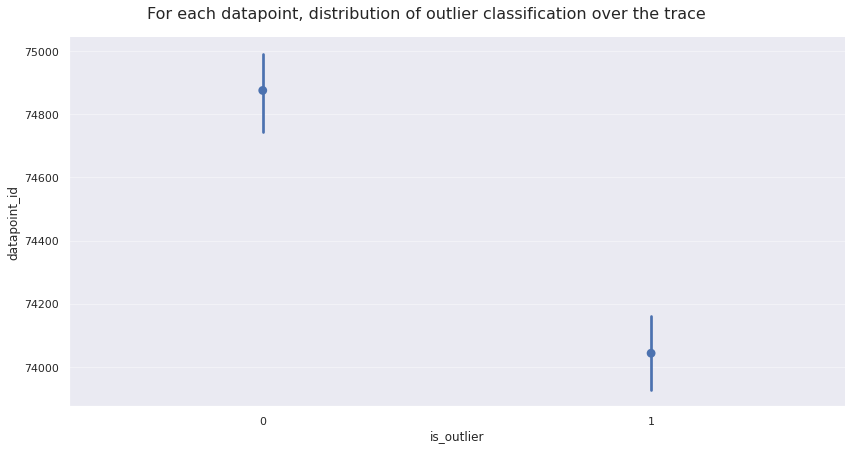

In [ ]:
gd = sns.catplot(
    y="datapoint_id",
    x="is_outlier",
    data=dfm_outlier_results,
    kind="point",
    join=False,
    height=6,
    aspect=2,
)
# _ = gd.fig.axes[0].set(xlim=(-0.05, 1.05), xticks=np.arange(0, 1.1, 0.1))
# _ = gd.fig.axes[0].axvline(x=0, color="b", linestyle=":")
# _ = gd.fig.axes[0].axvline(x=1, color="r", linestyle=":")
_ = gd.fig.axes[0].yaxis.grid(True, linestyle="-", which="major", color="w", alpha=0.4)
_ = gd.fig.suptitle(
    ("For each datapoint, distribution of outlier classification " + "over the trace"),
    y=1.04,
    fontsize=16,
)


In [ ]:
cutoff = 0.05
xy_train_small["classed_as_outlier"] = np.quantile(trc_hogg["is_outlier"], cutoff, axis=0) == 1
xy_train_small["classed_as_outlier"].value_counts()

False    485
True      15
Name: classed_as_outlier, dtype: int64

In [ ]:
xy_train_small["annotate_for_investigation"] = (
    np.quantile(trc_hogg["is_outlier"], 0.90, axis=0) == 1
)
xy_train_small["annotate_for_investigation"].value_counts()


True    500
Name: annotate_for_investigation, dtype: int64

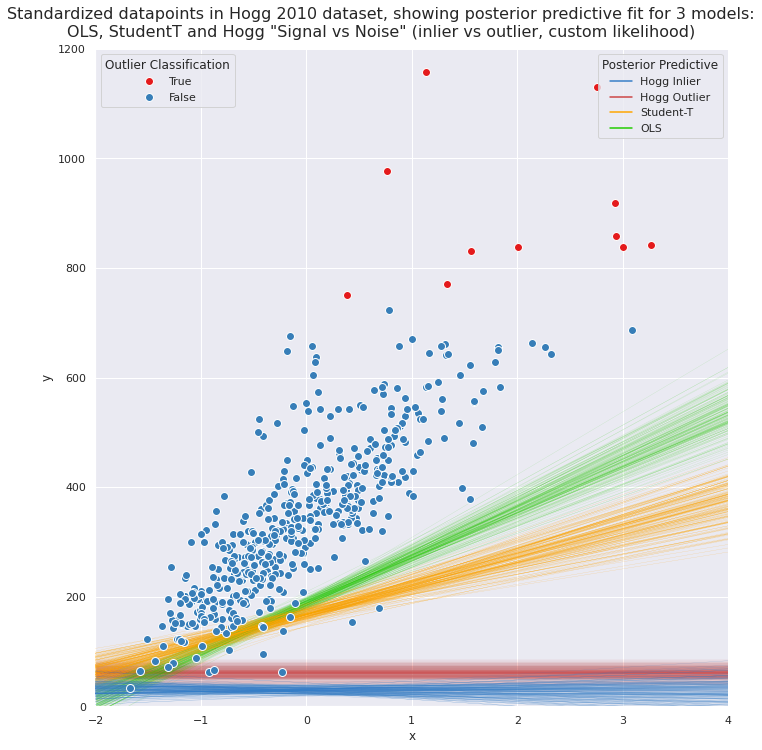

In [ ]:
eval_x = np.linspace(-3, 4, 10)

gd = sns.FacetGrid(
    xy_train_small,
    height=10,
    hue="classed_as_outlier",
    hue_order=[True, False],
    palette="Set1",
    legend_out=False,
)

# plot hogg outlier posterior distribution
outlier_mean = lambda x, s: s["y_est_out"] * x ** 0
pm.plot_posterior_predictive_glm(
    trc_hogg,
    lm=outlier_mean,
    eval=eval_x,
    samples=400,
    color="#CC4444",
    alpha=0.2,
    zorder=1,
)

# plot the 3 model (inlier) posterior distributions
lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x

pm.plot_posterior_predictive_glm(
    trc_ols,
    lm=lm,
    eval=eval_x,
    samples=200,
    color="#22CC00",
    alpha=0.3,
    zorder=2,
)

pm.plot_posterior_predictive_glm(
    trc_studentt,
    lm=lm,
    eval=eval_x,
    samples=200,
    color="#FFA500",
    alpha=0.5,
    zorder=3,
)

pm.plot_posterior_predictive_glm(
    trc_hogg,
    lm=lm,
    eval=eval_x,
    samples=200,
    color="#357EC7",
    alpha=0.5,
    zorder=4.0,
)
_ = plt.title(None)

line_legend = plt.legend(
    [
        Line2D([0], [0], color="#357EC7"),
        Line2D([0], [0], color="#CC4444"),
        Line2D([0], [0], color="#FFA500"),
        Line2D([0], [0], color="#22CC00"),
    ],
    ["Hogg Inlier", "Hogg Outlier", "Student-T", "OLS"],
    loc="upper right",
    title="Posterior Predictive",
)
_ = gd.fig.get_axes()[0].add_artist(line_legend)

# # plot points
# # _ = gd.map(
# #     plt.errorbar,
# #     "x",
# #     "y",
# #     "sigma_y",
# #     "sigma_x",
# #     marker="o",
# #     ls="",
# #     markeredgecolor="w",
# #     markersize=10,
# #     zorder=5,
# # ).add_legend()
_ = gd.map(
    plt.plot,
    "x",
    "y",
    marker="o",
    ls="",
    markeredgecolor="w",
    markersize=8,
    zorder=5,
).add_legend()
# gd.add_legend()
_ = gd.ax.legend(loc="upper left", title="Outlier Classification")

# # annotate the potential outliers
# for idx, r in xy_train_small.loc[xy_train_small["annotate_for_investigation"]].iterrows():
#     _ = gd.axes.ravel()[0].annotate(
#         s=idx,
#         xy=(r["x"], r["y"]),
#         xycoords="data",
#         xytext=(7, 7),
#         textcoords="offset points",
#         color="#999999",
#         zorder=4,
#         fontsize=6,
#     )

# ## create xlims ylims for plotting
# # x_ptp = np.ptp(xy_train_small["x"].values) / 3.3
# # y_ptp = np.ptp(xy_train_small["y"].values) / 3.3
# # xlims = (xy_train_small["x"].min() - x_ptp, xy_train_small["x"].max() + x_ptp)
# # ylims = (xy_train_small["y"].min() - y_ptp, xy_train_small["y"].max() + y_ptp)
ylims = (0, 1200)
xlims = (-2, 4)
_ = gd.axes.ravel()[0].set(ylim=ylims, xlim=xlims)
_ = gd.fig.suptitle(
    (
        "Standardized datapoints in Hogg 2010 dataset, showing "
        + "posterior predictive fit for 3 models:\nOLS, StudentT and Hogg "
        + '"Signal vs Noise" (inlier vs outlier, custom likelihood)'
    ),
    y=1.04,
    fontsize=16,
)


In [ ]:
for  s in [trc_ols, trc_studentt, trc_hogg]:
  print(s["b0_intercept"].mean(), s["b1_slope"].mean())

187.23380011793785 87.70833128582227
168.42353634461173 52.49959411607759
29.124391453465233 -1.1506209669766267


In [ ]:
trc_hogg['b1_slope']

array([-1.47494637,  2.74441781, -6.86348315, ...,  3.03991596,
        2.10166362, -9.90984422])

# TFP
https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
# Negative likelihood -log P(rv_y = y)
# rv_y : random variable, y: actual value
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [ ]:
x = y1_cb_train[:,[0]]
y = y_train_sp[y_name].astype(float).values
x_tst = y1_cb_test[:, [0]]

In [ ]:
# The posterior Mean and Variance are learned
model = tf.keras.Sequential([tf.keras.Input(shape=(x.shape[1],)),
                             tf.keras.layers.Dense(1+1), # mean and variance
                             tfp.layers.DistributionLambda(lambda t:
                                                           tfd.Normal(loc=t[...,:1], 
                                                                      scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])) 
                                                           )
                             ])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss=negloglik
              )
N = 146955
model.fit(x[:N], y[:N], epochs=100, verbose=0)

In [ ]:
x.shape

(146955, 1)

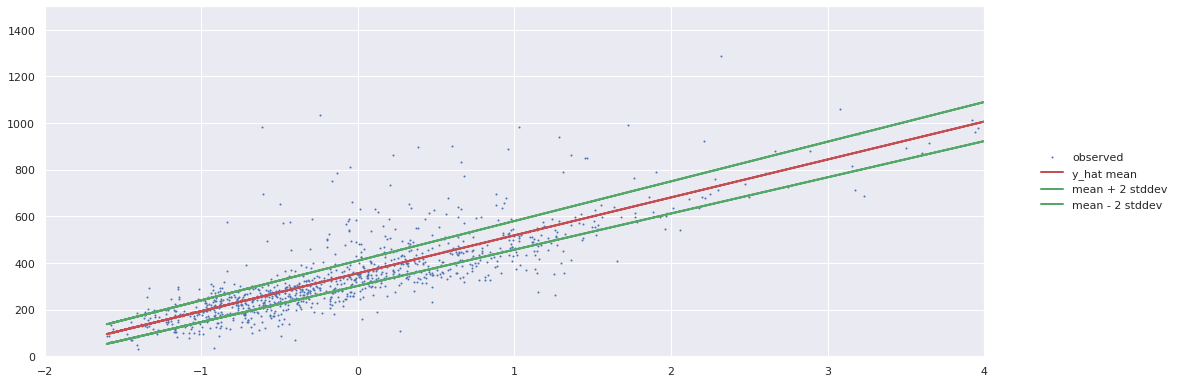

In [ ]:
def plot_predictions(model, x, y, x_tst):
  plt.figure(figsize=[15, 6])  # inches
  plt.clf();
  plt.plot(x, y, 'b.', label='observed', markersize=2);

  y_tst_posterior_dist = model(x_tst)
  y_tst_posterior_means = y_tst_posterior_dist.mean()
  plt.plot(x_tst, y_tst_posterior_means,'r', label='y_hat mean', linewidth=2);

  s = y_tst_posterior_dist.stddev()
  plt.plot(x_tst, y_tst_posterior_means + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
  plt.plot(x_tst, y_tst_posterior_means - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

  plt.xlim(-2.,4);
  plt.ylim(0.,1500);

  # # plt.yticks(np.linspace(0, 15, 4)[1:]);
  # # x_range = [x.min(), x.max()]
  # # plt.xticks(np.linspace(*x_range, num=9));

  # ax=plt.gca();
  # ax.xaxis.set_ticks_position('bottom')
  # ax.yaxis.set_ticks_position('left')
  # ax.spines['left'].set_position(('data', 0))
  # ax.spines['top'].set_visible(False)
  # ax.spines['right'].set_visible(False)
  # #ax.spines['left'].set_smart_bounds(True)
  # #ax.spines['bottom'].set_smart_bounds(True)
  plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

n = 1000
plot_predictions(model, x[:n], y[:n], x[:n])

In [ ]:
# using student-t rather than normal
# https://docs.pymc.io/notebooks/GLM.html
model_st = tf.keras.Sequential([tf.keras.Input(shape=(x.shape[1],)),
                             tf.keras.layers.Dense(1+1+2), # mean and variance
                             tfp.layers.DistributionLambda(lambda t:
                                                           tfd.StudentT(
                                                               loc=t[...,:1], 
                                                               scale=1e-3 + tf.math.softplus(0.05 * t[...,1:2]),
                                                               df=1.0 + tf.math.softplus(0.05 * t[...,2:]),
                                                               ) 
                                                           )
                             ])
model_st.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss=negloglik
              )
N = 146955
model_st.fit(x[:N], y[:N], epochs=100, verbose=0)

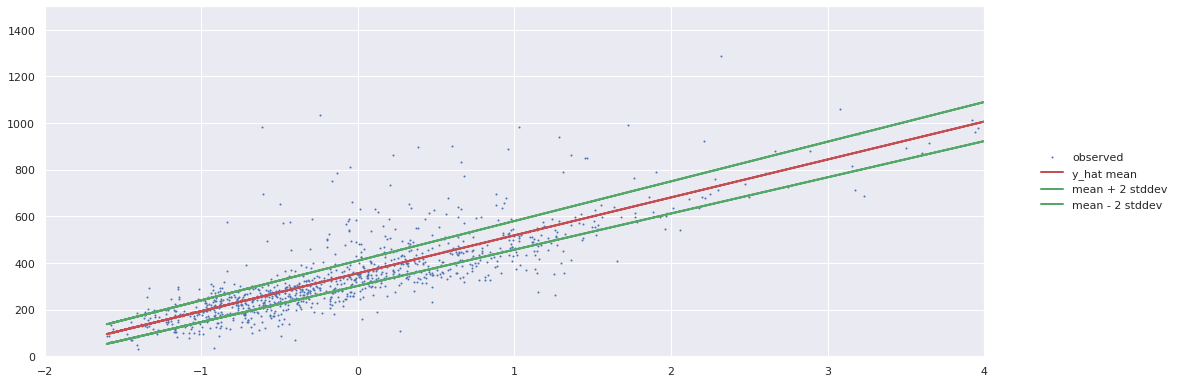

In [ ]:
n = 1000
plot_predictions(model, x[:n], y[:n], x[:n])

## Gaussian Process

In [ ]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

In [ ]:
x_range = [x.min(), x.max()]
x_range

[-2.4511162505991786, 52.97537125083227]

In [ ]:
# Build model.
num_inducing_points = 40

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    # tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, 
                        num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32

# !!!! Loss 
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=100, verbose=False)



/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:311: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


In [ ]:
# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

## R3 for all

In [ ]:
#@title Computes R2
# Gets the R3 for the 3 targets Y_NAMES.
# res_dfs are the respective residual dataframes.

# models = [ALL_RESULTS[0].model, ALL_RESULTS[1].model]

# r2s, res_dfs = run_model.r2_score_all(
#     models=models,
#     x_test_sp_list=[x_test_sp_4y0, x_test_sp],
#     y_test_sp=y_test_sp)

# Save model

In [ ]:
# Save model
SAVE_MODEL_DIR = "models/"

import datetime
for i in range(2):
  MODEL_FILE = f"catboost.15a.{datetime.datetime.now():%Y%m%d_%H%M}.Y{i}.model"
  m = ALL_RESULTS[i].model
  m.save_model(SAVE_MODEL_DIR + MODEL_FILE)

In [ ]:
#@title Reload models
# Reload model
SAVE_MODEL_DIR = "models/"
models = []
for i in range(2):
  MODEL_FILE = f"catboost.15a.{datetime.datetime.now():%Y%m%d_%H%M}.Y{i}.model"
  m = catboost.CatBoostRegressor()
  m = m.load_model(SAVE_MODEL_DIR + MODEL_FILE)
  models.append(m)

mY0 = models[0]
mY1 = models[1]

# Recent bugs in catboost
mY0._init_params["verbose"]=None
mY1._init_params["verbose"]=None

# Submission

In [ ]:
#@title refits models with all train data
%%time
# Fit models with all data
models = [None]*2

models[0] = catboost.CatBoostRegressor(
    loss_function='Huber:delta=600', 
    learning_rate=0.05,
    iterations = 9067,
    #early_stopping_rounds = 200,
    cat_features = cat_features_4y0_idx,
    verbose=200,
    depth=6,
    l2_leaf_reg=10,
)
models[0].fit(x_train_4y0, y_train[Y_NAMES[0]])

models[1] = catboost.CatBoostRegressor(
    loss_function='Huber:delta=600', 
    learning_rate=0.05,
    iterations = 13672,
    #early_stopping_rounds = 200,
    cat_features = cat_features_idx,
    verbose=200,
    
    depth=6,
    l2_leaf_reg=10,
)
models[1].fit(x_train, y_train[Y_NAMES[1]])

In [ ]:
#@title check R2
r2s, res_dfs = run_model.r2_score_all(models=models, 
                                      x_test_sp_list=[x_test_sp_4y0, x_test_sp],
                                      y_test_sp=y_test_sp)
r2s

In [ ]:
#@title create submission dataframe
submit_df = run_model.create_submit_csv(models=models, 
                                        data_dir='data/', 
                                        feats_4y0 = feats_4y0,
                                        data_prep_dir='data/prepared/')
submit_df.head()

In [ ]:
submit_file = f"nmq_submission.15a.{datetime.datetime.now():%Y%m%d_%H%M}.csv"
submit_df.to_csv(DATA_DIR + submit_file, index=True)

## Score
https://challengedata.ens.fr/participants/challenges/21<br>

GPS Tracks, 0426, 0.2833364516013681<br>
Additional Feats, 0425, 0.27959089265707465<br>


# Analyze

In [ ]:
#@title feature importance
pd.concat([
     models[i].get_feature_importance(prettified=True) for i in range(2)
],axis=1).head(30)